# Beaver Image Classifier

## Set Up Environment

In [31]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf
import pathlib
import random
import os
import IPython.display as display
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from preprocessing import load_and_preprocess_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Make Dataset

In [52]:
data = pathlib.Path('/Users/nkacoroski/Flatiron/module_4/beaver_image_classifier/data')

for item in data.iterdir():
    print(item)

/Users/nkacoroski/Flatiron/module_4/beaver_image_classifier/data/not_beaver
/Users/nkacoroski/Flatiron/module_4/beaver_image_classifier/data/beaver


In [53]:
all_image_paths = list(data.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

2255

In [54]:
all_image_paths[:5]

['/Users/nkacoroski/Flatiron/module_4/beaver_image_classifier/data/beaver/s1c1_20190427_215807.jpg',
 '/Users/nkacoroski/Flatiron/module_4/beaver_image_classifier/data/beaver/s1c2_20190603_052434.jpg',
 '/Users/nkacoroski/Flatiron/module_4/beaver_image_classifier/data/beaver/s1c1_20190426_030902.jpg',
 '/Users/nkacoroski/Flatiron/module_4/beaver_image_classifier/data/beaver/s1c1_20190420_023753.jpg',
 '/Users/nkacoroski/Flatiron/module_4/beaver_image_classifier/data/beaver/s1c1_20190530_024508.jpg']

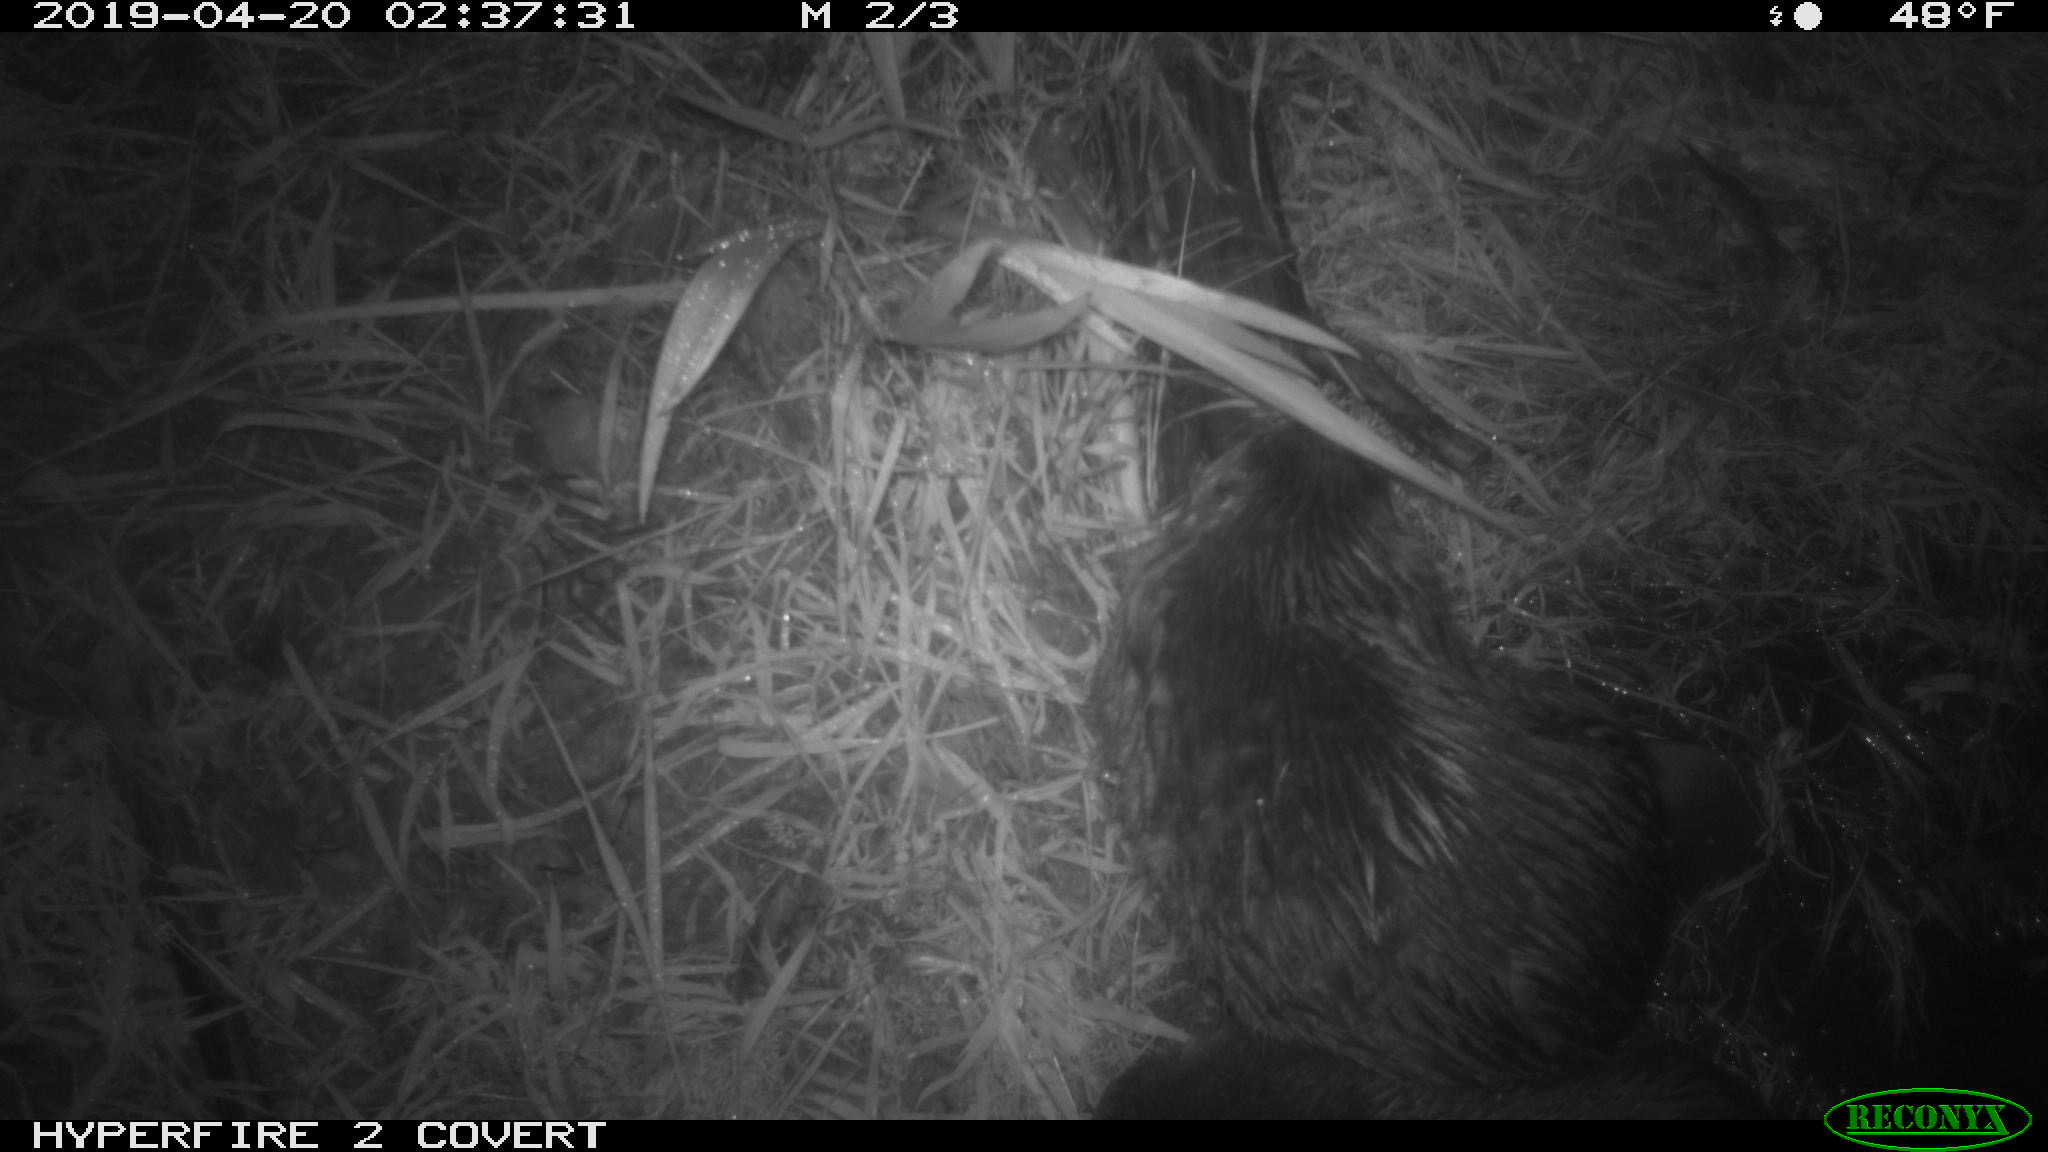

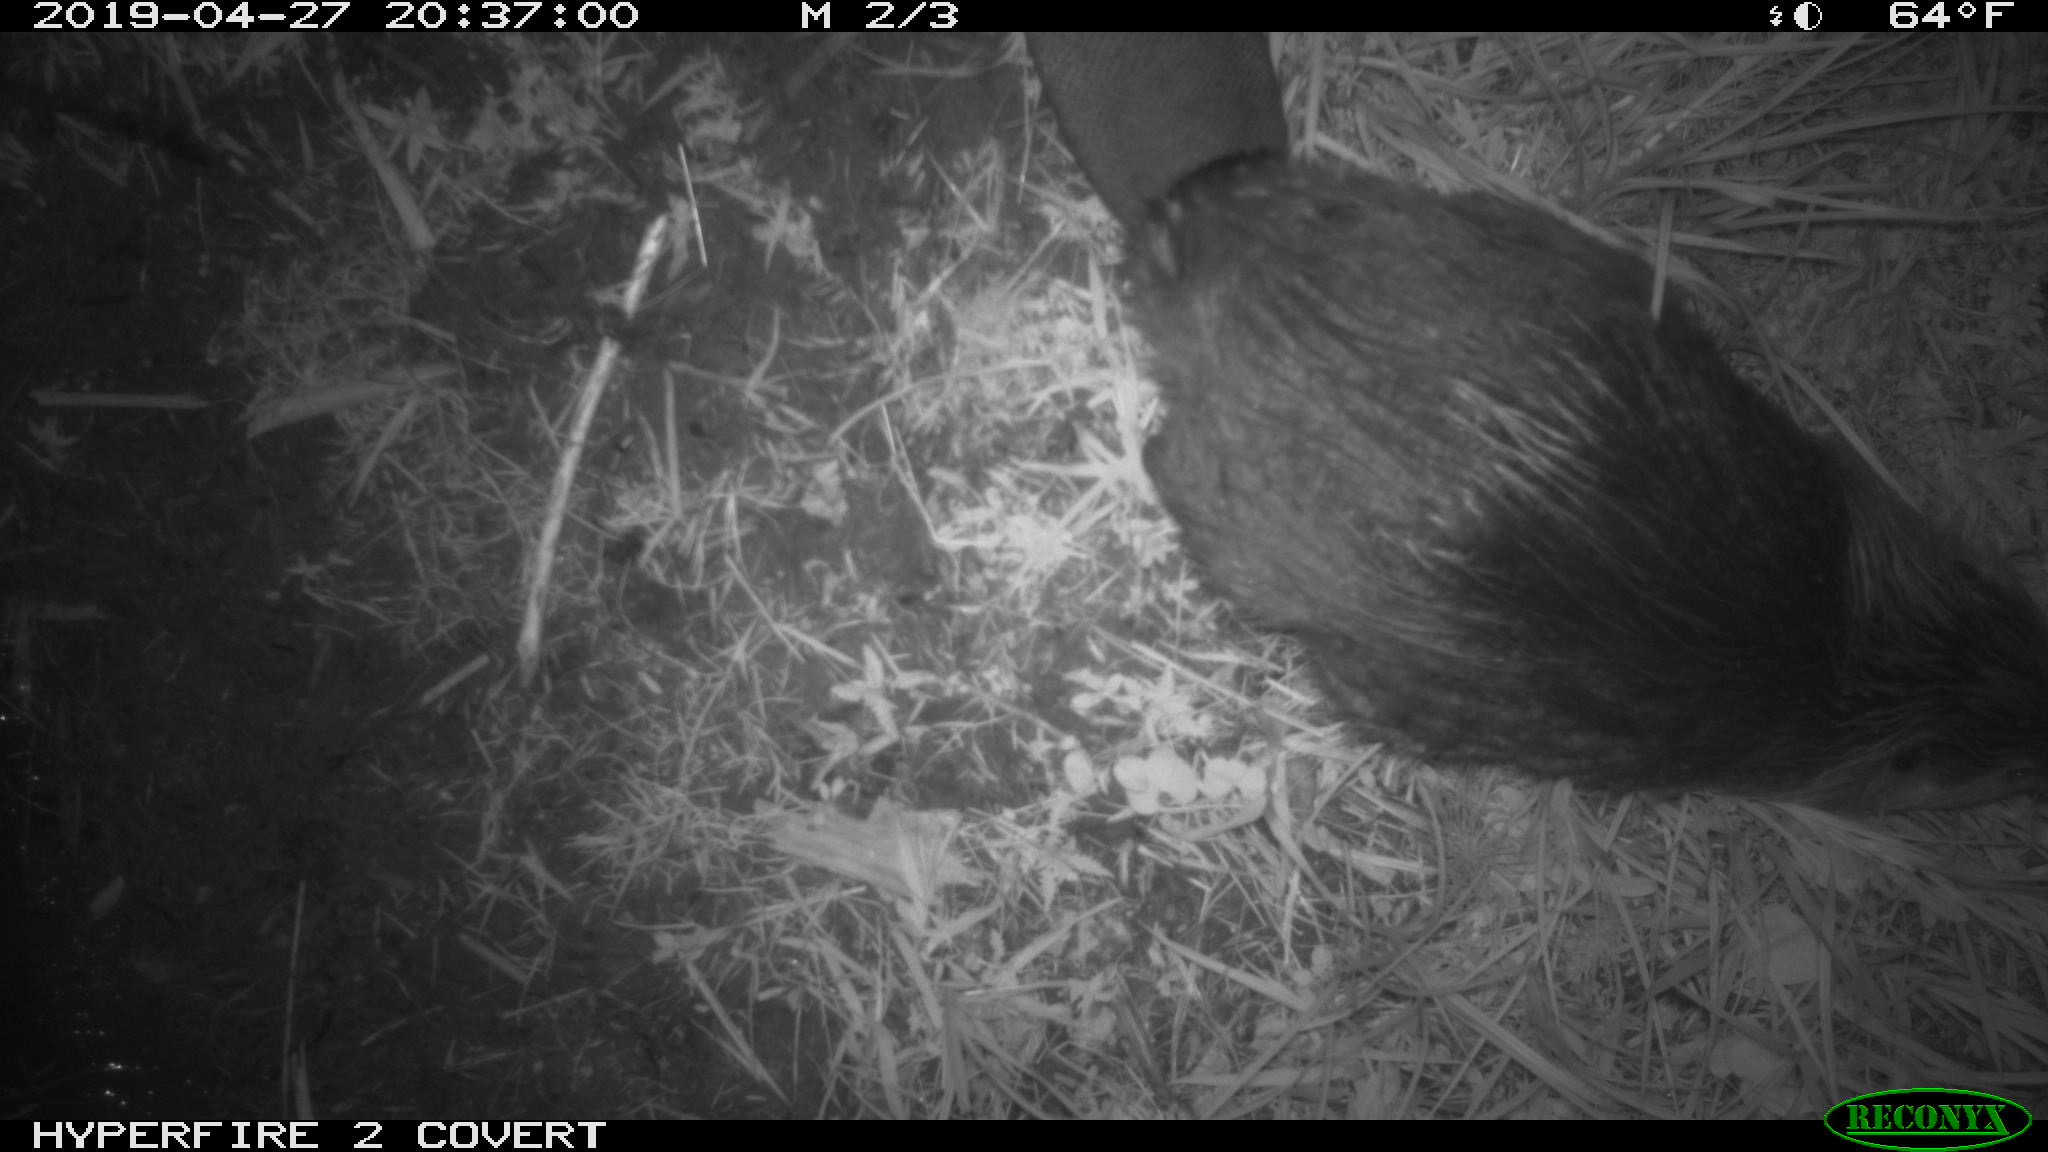

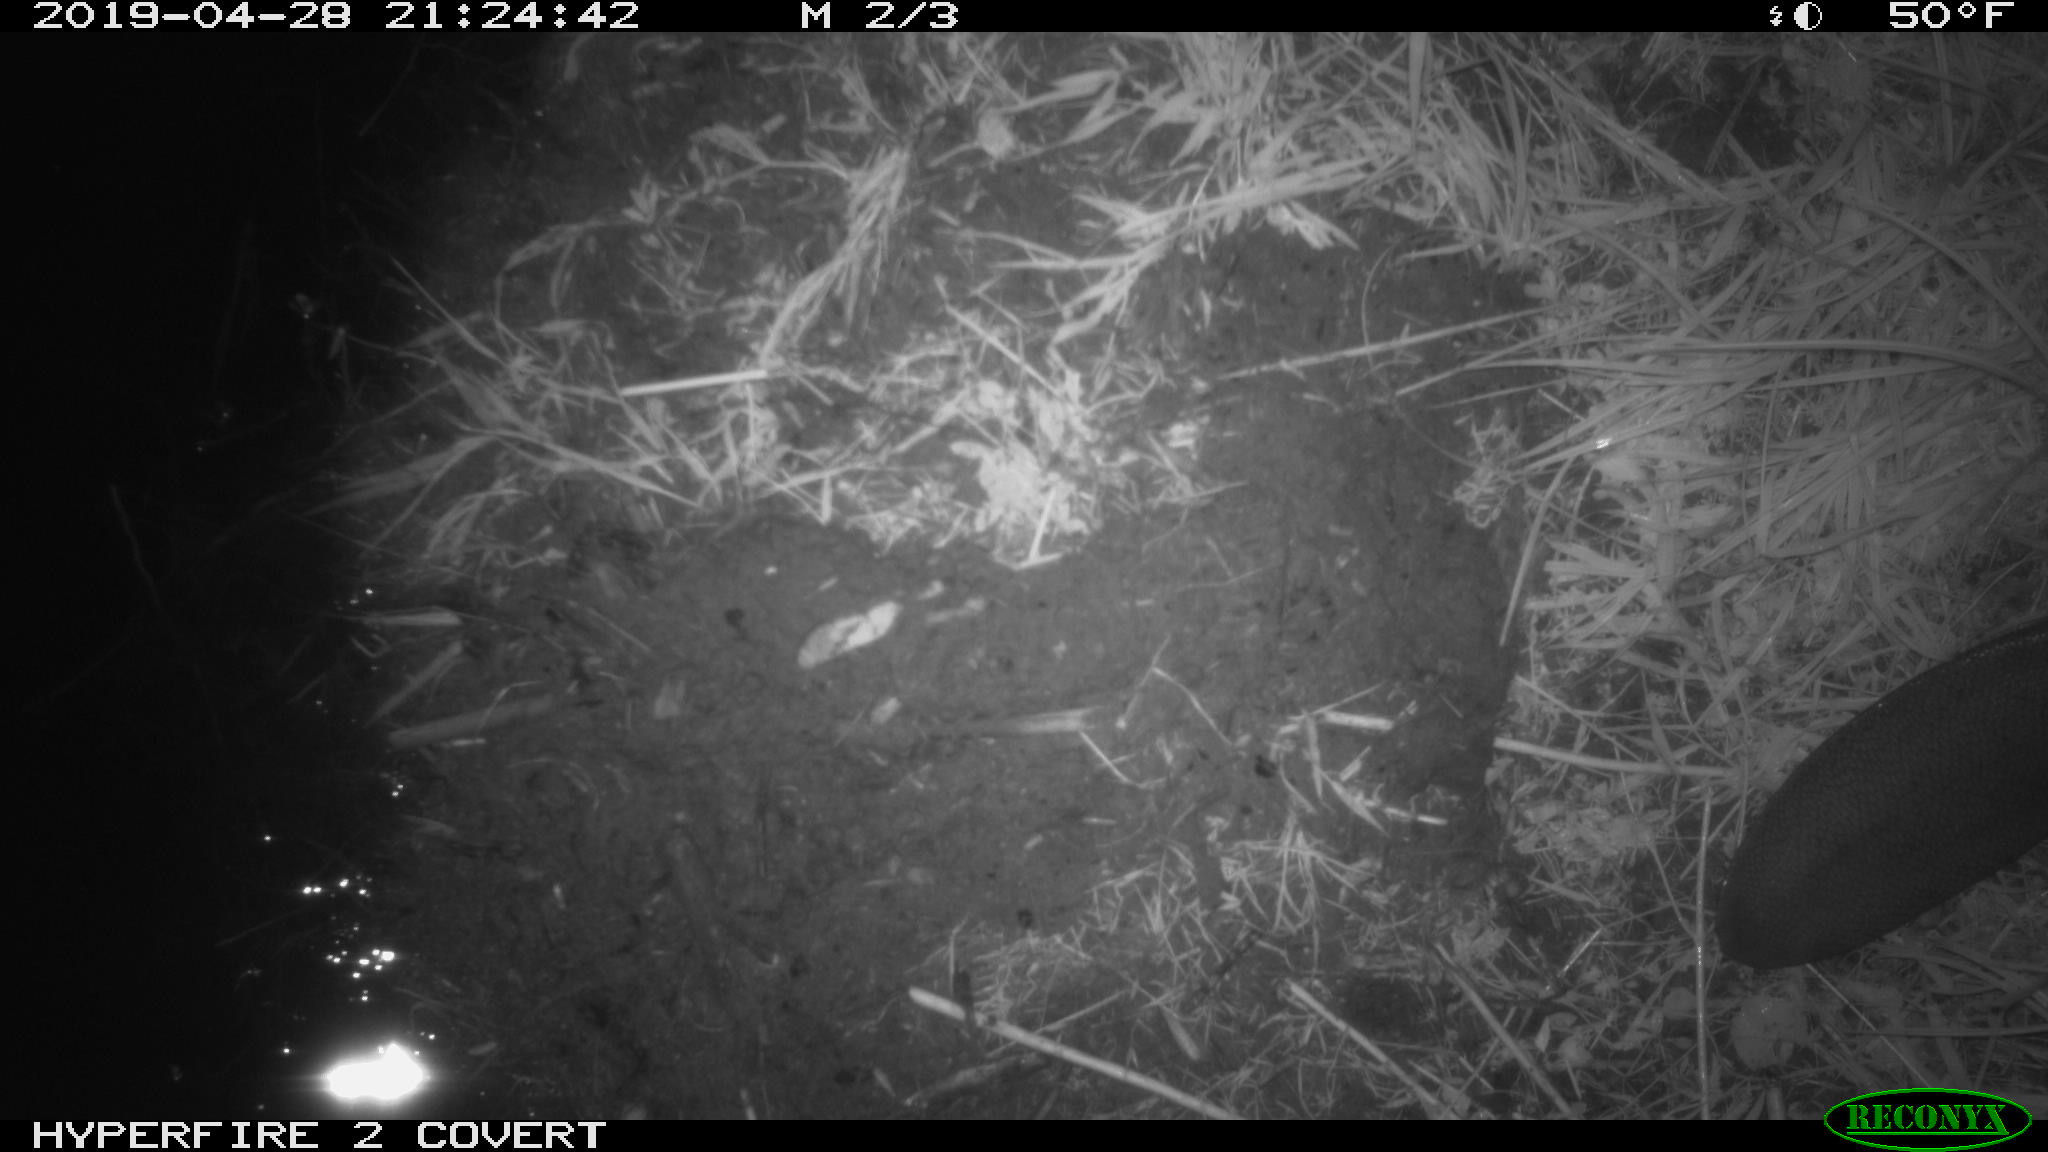

In [15]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))

In [55]:
label_names = sorted(item.name for item in data.glob('*/') if item.is_dir())
label_names

['beaver', 'not_beaver']

In [56]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'beaver': 0, 'not_beaver': 1}

In [57]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_labels[:10])

First 10 label indices:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [58]:
img_path = all_image_paths[0]
img_path

'/Users/nkacoroski/Flatiron/module_4/beaver_image_classifier/data/beaver/s1c1_20190427_215807.jpg'

In [59]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=6515, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x0...


In [60]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(1152, 2048, 3)
<dtype: 'uint8'>


In [61]:
img_final = tf.image.resize(img_tensor, [224, 224])
img_final /= 255

print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(224, 224, 3)
0.0
0.9356316


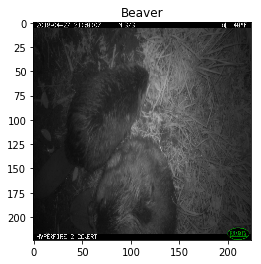

In [62]:
image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid = False
plt.title(label_names[label].title())
print()

In [63]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [64]:
print(paths_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [65]:
image_ds = paths_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

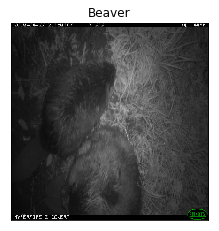

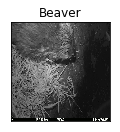

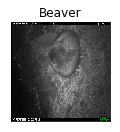

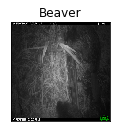

In [66]:
plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid = False
    plt.xticks([])
    plt.yticks([])
    plt.title(label_names[label].title())
    plt.show()

In [67]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [68]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

beaver
beaver
beaver
beaver
beaver
not_beaver
beaver
beaver
beaver
beaver


In [69]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [70]:
print(image_label_ds)

<ZipDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [71]:
BATCH_SIZE = 32

ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [72]:
ds = image_label_ds.shuffle(buffer_size=image_count, seed=1)
ds = ds.repeat(count=image_count)
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [74]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
mobile_net.trainable=False

In [75]:
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

In [76]:
image_batch, label_batch = next(iter(keras_ds))

In [77]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 1280)


In [78]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [79]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -1.688493
max logit: 2.3510962

Shape: (32, 2)


In [88]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [81]:
len(model.trainable_variables

2

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [83]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

71.0

In [89]:
history = model.fit(ds, epochs=10, steps_per_epoch=71)

Epoch 1/10
71/71 [==============================] - 303s 4s/step - loss: 3.4896 - accuracy: 0.7738
Epoch 2/10
71/71 [==============================] - 230s 3s/step - loss: 3.4896 - accuracy: 0.7738
Epoch 3/10
71/71 [==============================] - 223s 3s/step - loss: 3.4896 - accuracy: 0.7738
Epoch 4/10
71/71 [==============================] - 223s 3s/step - loss: 3.5100 - accuracy: 0.7724
Epoch 5/10
71/71 [==============================] - 222s 3s/step - loss: 3.4625 - accuracy: 0.7755
Epoch 6/10
71/71 [==============================] - 226s 3s/step - loss: 3.5304 - accuracy: 0.7711
Epoch 7/10
71/71 [==============================] - 234s 3s/step - loss: 3.4625 - accuracy: 0.7755
Epoch 8/10
71/71 [==============================] - 234s 3s/step - loss: 3.4421 - accuracy: 0.7768
Epoch 9/10
71/71 [==============================] - 233s 3s/step - loss: 3.4693 - accuracy: 0.7751
Epoch 10/10
71/71 [==============================] - 229s 3s/step - loss: 3.5168 - accuracy: 0.7720
